Solar Power Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,root_mean_squared_error,mean_absolute_percentage_error

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving Actual_38.55_-75.15_2006_UPV_49MW_5_Min.csv to Actual_38.55_-75.15_2006_UPV_49MW_5_Min.csv


In [ ]:
file_path = 'Actual_38.55_-75.15_2006_UPV_49MW_5_Min.csv'
df = pd.read_csv(file_path)

def parse_timestamp(ts):
    for fmt in ('%m/%d/%Y %H:%M', '%m/%d/%y %H:%M'):
        try:
            return pd.to_datetime(ts, format=fmt)
        except ValueError:
            continue
    return pd.NaT

df['timestamp'] = df['LocalTime'].apply(parse_timestamp)
df.set_index('timestamp', inplace=True)
df = df[['Power(MW)']]

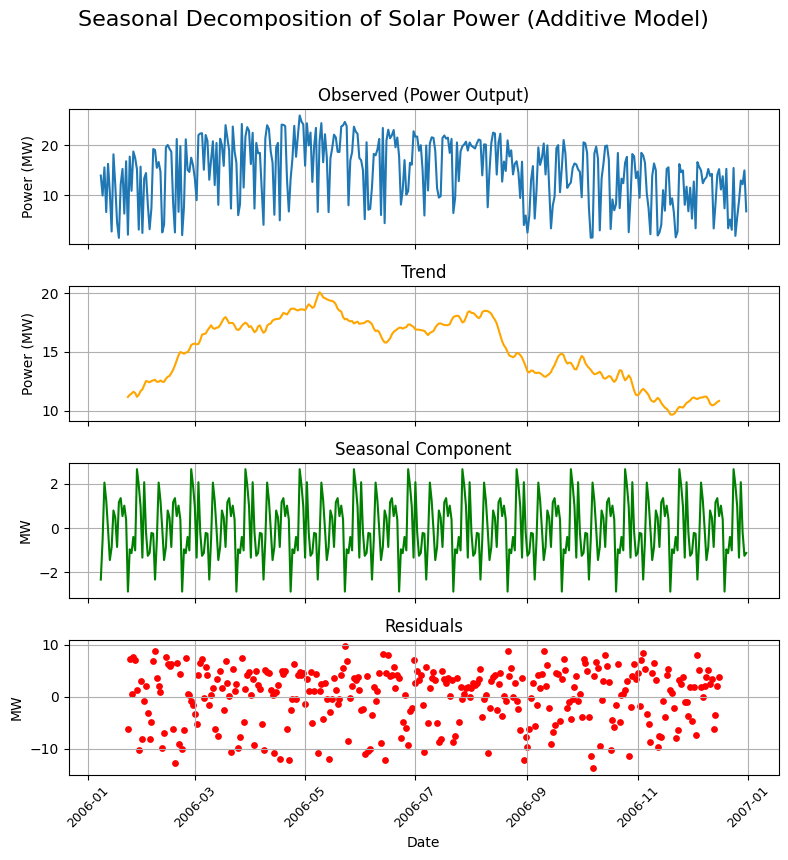

In [ ]:
df_daily = df.between_time('06:00', '18:00').resample('D').mean().dropna()

df_daily['day_of_week']=df_daily.index.dayofweek
df_daily['month']=df_daily.index.month
df_daily['lag_1']=df_daily['Power(MW)'].shift(1)
df_daily['lag_2']=df_daily['Power(MW)'].shift(7)
df_daily['rolling_mean_7']=df_daily['Power(MW)'].rolling(7).mean()
df_daily.dropna(inplace=True)

series = df_daily['Power(MW)']
decomposition = seasonal_decompose(series, model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(8, 9), sharex=True)

axes[0].plot(series, label='Observed')
axes[0].set_title('Observed (Power Output)')
axes[0].set_ylabel('Power (MW)')
axes[0].grid(True)

# Trend
axes[1].plot(decomposition.trend, label='Trend', color='orange')
axes[1].set_title('Trend')
axes[1].set_ylabel('Power (MW)')
axes[1].grid(True)

# Seasonal
axes[2].plot(decomposition.seasonal, label='Seasonal', color='green')
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('MW')
axes[2].grid(True)

# Residuals
axes[3].scatter(decomposition.resid.index, decomposition.resid, label='Residuals', color='red', s=15)
axes[3].set_title('Residuals')
axes[3].set_ylabel('MW')
axes[3].set_xlabel('Date')
axes[3].grid(True)

for ax in axes:
    ax.tick_params(axis='x', rotation=45, labelsize=9)

fig.suptitle('Seasonal Decomposition of Solar Power (Additive Model)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
df_daily.to_csv('cleaned_daily_power.csv')
from google.colab import files
files.download('cleaned_daily_power.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Random Forest Regressor Model

In [ ]:
train_set=df_daily[df_daily.index < '2006-11-01']
nov_actual_df= df_daily[(df_daily.index>='2006-11-01') & (df_daily.index<'2006-12-01')]
nov_df= nov_actual_df.copy()
dec_df=df_daily[df_daily.index>='2006-12-01']
split_idx=int(len(train_set)*0.8)
#print(f"Train set size: {len(train_set)}")

train_df=train_set.iloc[:split_idx]
test_df=train_set.iloc[split_idx:]

feature_cols=['lag_1','lag_2','rolling_mean_7','day_of_week','month']
target_col='Power(MW)'

X_train=train_df[feature_cols]
y_train=train_df[target_col]

X_test=test_df[feature_cols]
y_test=test_df[target_col]

In [ ]:
rfr_model=RandomForestRegressor(n_estimators=300,max_depth=10,min_samples_leaf=4,random_state=42,n_jobs=-1)
rfr_model.fit(X_train,y_train)

y_pred= rfr_model.predict(X_test)
mse_test=mean_squared_error(y_test,y_pred)
print(f"Mean Squared Error: {mse_test:.2f}")
print(f"R squared error: {r2_score(y_test,y_pred):.2f}")

rfr_model.fit(train_set[feature_cols],train_set[target_col])
nov_pred=rfr_model.predict(nov_df[feature_cols])
nov_df['Power(MW)']=nov_pred

Mean Squared Error: 28.86
R squared error: 0.06


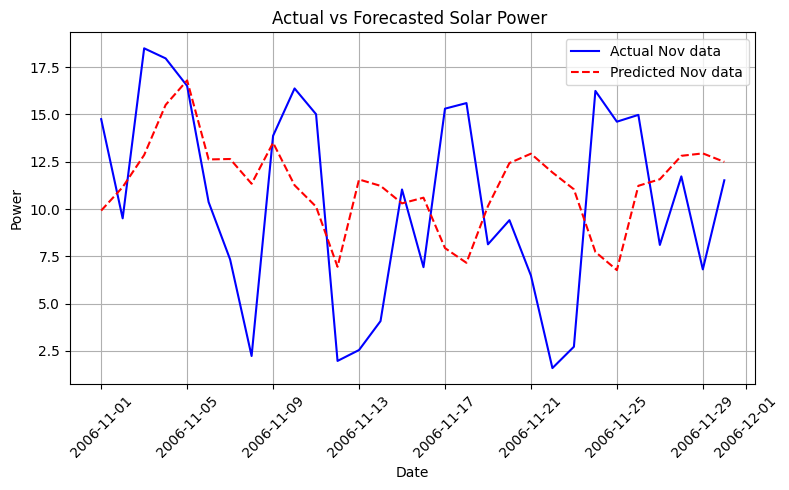

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(nov_actual_df.index,nov_actual_df['Power(MW)'],label='Actual Nov data ',color='blue')
plt.plot(nov_df.index,nov_df['Power(MW)'],label='Predicted Nov data',color='red',linestyle='--')
plt.title('Actual vs Forecasted Solar Power ')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mse_nov=mean_squared_error(nov_actual_df['Power(MW)'],nov_df['Power(MW)'])
mae_nov=mean_absolute_error(nov_actual_df['Power(MW)'],nov_df['Power(MW)'])
r2_nov=r2_score(nov_actual_df['Power(MW)'],nov_df['Power(MW)'])
rfr_rmse=root_mean_squared_error(nov_actual_df['Power(MW)'],nov_df['Power(MW)'])
rfr_mape=mean_absolute_percentage_error(nov_actual_df['Power(MW)'],nov_df['Power(MW)'])


print(f"Mean Squared Error (Nov): {mse_nov:.2f}")
print(f"Mean Absolute Error (Nov): {mae_nov:.2f}")
print(f"R-squared (Nov): {r2_nov:.2f}")
print(f"Root mean squared Error (Nov): {rfr_rmse:.2f}")
print(f"Mean Absolute Percentage Error (Nov): {rfr_mape:.2f}%")

Mean Squared Error (Nov): 31.92
Mean Absolute Error (Nov): 4.84
R-squared (Nov): -0.18
Root mean squared Error (Nov): 5.65
Mean Absolute Percentage Error (Nov): 1.00%


In [ ]:
#Prophet Model

In [ ]:
df_prophet=train_set.reset_index()[['timestamp','Power(MW)']]
df_prophet.rename(columns={'timestamp':'ds','Power(MW)':'y'},inplace=True)
prophet_model=Prophet(yearly_seasonality=False,daily_seasonality=True,weekly_seasonality=True)
prophet_model.add_seasonality(name='monthly', period=30.4375, fourier_order=6)

prophet_model.fit(df_prophet)
nov_future_df=nov_df.reset_index()[['timestamp']]
nov_future_df.rename(columns={'timestamp':'ds'},inplace=True)
nov_forecast=prophet_model.predict(nov_future_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpph2h0mhf/qm678f8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpph2h0mhf/mxumlj87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80351', 'data', 'file=/tmp/tmpph2h0mhf/qm678f8h.json', 'init=/tmp/tmpph2h0mhf/mxumlj87.json', 'output', 'file=/tmp/tmpph2h0mhf/prophet_modelv0lup5ig/prophet_model-20250708043515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:35:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


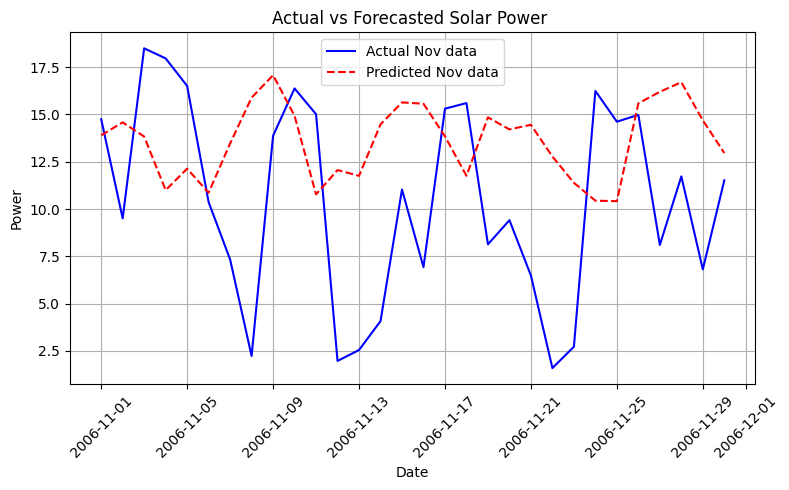

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(nov_actual_df.index,nov_actual_df['Power(MW)'],label='Actual Nov data ',color='blue')
plt.plot(nov_forecast['ds'],nov_forecast['yhat'],label='Predicted Nov data',color='red',linestyle='--')
plt.title('Actual vs Forecasted Solar Power ')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
mse_nov=mean_squared_error(nov_actual_df['Power(MW)'],nov_forecast['yhat'])
mae_nov=mean_absolute_error(nov_actual_df['Power(MW)'],nov_forecast['yhat'])
r2_nov=r2_score(nov_actual_df['Power(MW)'],nov_forecast['yhat'])
pro_rmse=root_mean_squared_error(nov_actual_df['Power(MW)'],nov_forecast['yhat'])
pro_mape=mean_absolute_percentage_error(nov_actual_df['Power(MW)'],nov_forecast['yhat'])


print(f"Mean Squared Error (Nov): {mse_nov:.2f}")
print(f"Mean Absolute Error (Nov): {mae_nov:.2f}")
print(f"R-squared (Nov): {r2_nov:.2f}")
print(f"Root mean squared Error (Nov): {pro_rmse:.2f}")
print(f"Mean Absolute Percentage Error (Nov): {pro_mape:.2f}%")

Mean Squared Error (Nov): 43.85
Mean Absolute Error (Nov): 5.72
R-squared (Nov): -0.62
Root mean squared Error (Nov): 6.62
Mean Absolute Percentage Error (Nov): 1.28%


In [ ]:
#XG Boost Regressor

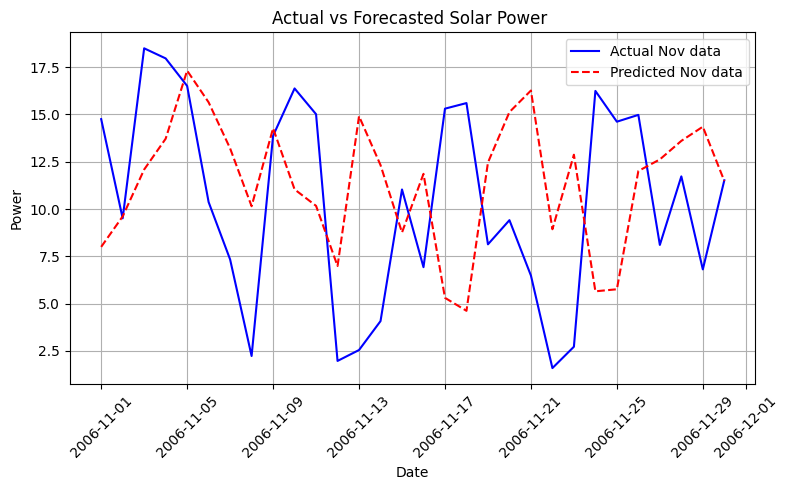

Mean Squared Error: 45.41
R-squared: -0.68
Mean Absolute Error: 5.85
Root Mean Squared Error: 6.74
Mean Absolute Percentage Error: 1.09%


In [ ]:
#df_xg=train_set.reset_index()[['timestamp','Power(MW)']]
xg_model=XGBRegressor(n_estimators=700,learning_rate=0.02,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=42)

xg_model.fit(train_set[feature_cols], train_set[target_col])
X_nov = nov_df[feature_cols]
nov_df['xg_pred'] = xg_model.predict(X_nov)

#Visualization
plt.figure(figsize=(8,5))
plt.plot(nov_actual_df.index,nov_actual_df['Power(MW)'],label='Actual Nov data ',color='blue')
plt.plot(nov_df.index,nov_df['xg_pred'],label='Predicted Nov data',color='red',linestyle='--')
plt.title('Actual vs Forecasted Solar Power ')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Evaluation metrics
xg_rmse= root_mean_squared_error(nov_actual_df['Power(MW)'],nov_df['xg_pred'])
xg_mape= mean_absolute_percentage_error(nov_actual_df['Power(MW)'],nov_df['xg_pred'])

print(f"Mean Squared Error: {mean_squared_error(nov_actual_df['Power(MW)'],nov_df['xg_pred']):.2f}")
print(f"R-squared: {r2_score(nov_actual_df['Power(MW)'],nov_df['xg_pred']):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(nov_actual_df['Power(MW)'],nov_df['xg_pred']):.2f}")
print(f"Root Mean Squared Error: {xg_rmse:.2f}")
print(f"Mean Absolute Percentage Error: {xg_mape:.2f}%")


In [ ]:
#Light GBM

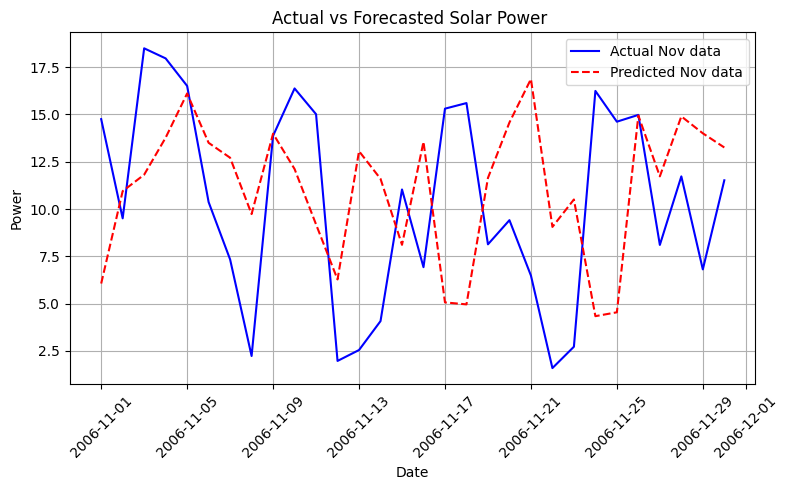

Mean Squared Error: 44.24
Mean Absolute Error: 5.75
R-squared: -0.63
Root Mean Squared Error: 6.65
Mean Absolute Percentage Error: 1.02%


In [ ]:
lgbm_model = LGBMRegressor(n_estimators=700, learning_rate=0.02, num_leaves=40, min_child_samples=15,random_state=42, verbosity=-1)

nov_full_df = nov_actual_df.copy()
nov_full_df['day_of_week'] = nov_full_df.index.dayofweek
nov_full_df['month'] = nov_full_df.index.month
combined_train_nov = pd.concat([train_set, nov_full_df])

nov_full_df['lag_1'] = combined_train_nov['Power(MW)'].shift(1).loc[nov_full_df.index]
nov_full_df['lag_2'] = combined_train_nov['Power(MW)'].shift(7).loc[nov_full_df.index]
nov_full_df['rolling_mean_7'] = combined_train_nov['Power(MW)'].rolling(7).mean().loc[nov_full_df.index]
nov_full_df.dropna(inplace=True)


feature_cols = ['lag_1', 'lag_2', 'rolling_mean_7', 'day_of_week', 'month']
target_col = 'Power(MW)'


lgbm_model.fit(train_set[feature_cols], train_set[target_col])
Lgbm_nov_full = nov_full_df[feature_cols]
nov_full_df['lgbm_pred'] = lgbm_model.predict(Lgbm_nov_full)

#Visualization
plt.figure(figsize=(8,5))
plt.plot(nov_actual_df.index,nov_actual_df['Power(MW)'],label='Actual Nov data ',color='blue')
plt.plot(nov_full_df.index,nov_full_df['lgbm_pred'],label='Predicted Nov data',color='red',linestyle='--')
plt.title('Actual vs Forecasted Solar Power ')
plt.xlabel('Date')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Evaluation metrics
bgm_rmse= root_mean_squared_error(nov_actual_df.loc[nov_full_df.index]['Power(MW)'],nov_full_df['lgbm_pred'])
bgm_mape= mean_absolute_percentage_error(nov_actual_df.loc[nov_full_df.index]['Power(MW)'],nov_full_df['lgbm_pred'])

print(f"Mean Squared Error: {mean_squared_error(nov_actual_df.loc[nov_full_df.index]['Power(MW)'],nov_full_df['lgbm_pred']):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(nov_actual_df.loc[nov_full_df.index]['Power(MW)'],nov_full_df['lgbm_pred']):.2f}")
print(f"R-squared: {r2_score(nov_actual_df.loc[nov_full_df.index]['Power(MW)'],nov_full_df['lgbm_pred']):.2f}")
print(f"Root Mean Squared Error: {bgm_rmse:.2f}")
print(f"Mean Absolute Percentage Error: {bgm_mape:.2f}%")

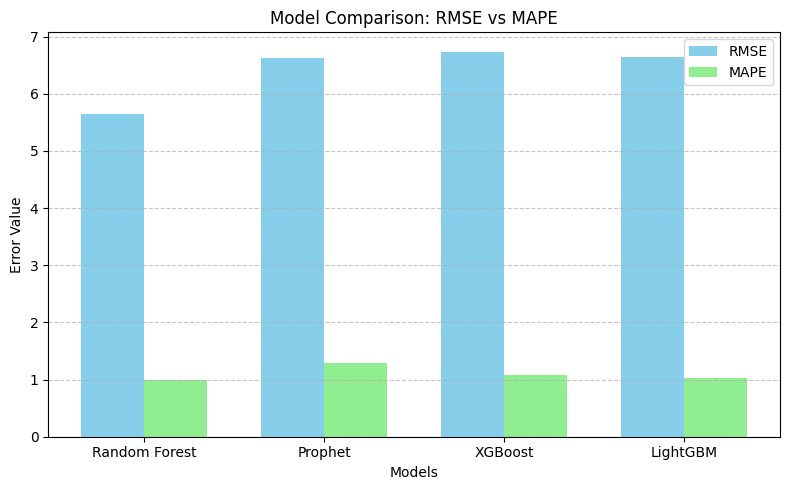

In [ ]:
models = ['Random Forest', 'Prophet', 'XGBoost', 'LightGBM']
rmse_values = [rfr_rmse, pro_rmse,xg_rmse, bgm_rmse]
mape_values = [rfr_mape, pro_mape, xg_mape, bgm_mape]

x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, rmse_values, width=width, label='RMSE', color='skyblue')
plt.bar([i + width for i in x], mape_values, width=width, label='MAPE', color='lightgreen')

plt.xlabel('Models')
plt.ylabel('Error Value')
plt.title('Model Comparison: RMSE vs MAPE')
plt.xticks([i + width / 2 for i in x], models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# ✅ STEP 1: Create Actual vs Predicted Comparison CSV
nov_df['Actual'] = nov_actual_df['Power(MW)'].values  # Add actual values

# For LightGBM, align index
nov_full_df['Actual'] = nov_actual_df.loc[nov_full_df.index]['Power(MW)']

# Create one table with all predictions
comparison_df = pd.DataFrame({
    'Date': nov_actual_df.index,
    'Actual': nov_actual_df['Power(MW)'].values,
    'RandomForest_Predicted': nov_df['Power(MW)'].values,
    'Prophet_Predicted': nov_forecast['yhat'].values,
    'XGBoost_Predicted': nov_df['xg_pred'].values,
    'LightGBM_Predicted': nov_full_df['lgbm_pred'].values
})

# ✅ STEP 2: Create Error Metrics Summary CSV
error_df = pd.DataFrame({
    'Model': ['Random Forest', 'Prophet', 'XGBoost', 'LightGBM'],
    'RMSE': [rfr_rmse, pro_rmse, xg_rmse, bgm_rmse],
    'MAPE': [rfr_mape, pro_mape, xg_mape, bgm_mape]
})

# ✅ STEP 3: Save as CSVs
comparison_df.to_csv("november_predictions.csv", index=False)
error_df.to_csv("model_error_summary.csv", index=False)

# ✅ STEP 4: Download files from Colab
from google.colab import files
files.download("november_predictions.csv")
files.download("model_error_summary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nov_df.to_csv("rfr_predictions.csv", index=False)
files.download("rfr_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>